In [268]:
import uclchem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import requests
from bs4 import BeautifulSoup
def get_density(history_file):
    df=pd.read_csv(history_file,skiprows=2)
    return df.iloc[-1,1]

# What Failed?

In [269]:
phase="three_phase"
models=pd.read_csv(f"../data/{phase}/models.csv")
complete=pd.read_hdf(f"../data/{phase}/final_abunds.hdf",key="df").reset_index(drop=True)
fails=models[~models["outputFile"].isin(complete["outputFile"])]
fails[["initialDens","zeta","radfield"]]=np.log10(fails[["initialDens","zeta","radfield"]])

/home/jon/.local/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [270]:
print(len(fails))
models=models.loc[~models.index.isin(fails.index)]

29


In [271]:
models.loc[models.index.isin(fails.index)]

,initialTemp,radfield,zeta,Av,outputFile,history,initialDens,rout


In [272]:
len(complete)

7287184

In [273]:
complete.loc[complete["Conserve C"]==False,"outputFile"].nunique()

0

# Stats
Once we're happy the output from UCLCHEM can be trusted, we need to move to a quantitative way to decide which species are the most apt to be called HITs.

My current thinking on this is that we group by physics and take the standard deviation. Then we group by species and take the average standard deviation of each species across different physical conditions. By doing this, the first calculation should return 0 for HITs as it won't matter which history (the only variable) you used, they'll give the same abundance. 

Then the second calculation will be closer to zero the more often this is true for different physical parameters.

In [274]:
models=pd.read_hdf(f"../data/{phase}/final_abunds.hdf",key="df").reset_index(drop=True)
models=models[models["Conserve C"]]
physics=["initialTemp","radfield","Av","zeta","rout","initialDens"]

In [275]:
models=models.drop(["outputFile","Conserve C"],axis=1)
models["Abundance"]=np.log10(models["Abundance"])
models=models[~models["Species"].str.contains("#")]
models=models[~models["Species"].str.contains("@")]

In [276]:
useless_species=models.groupby("Species")["Abundance"].median()
useless_species=useless_species[useless_species<-12]
useless_species=list(useless_species.index)
useless_species=useless_species+["H","H+","H2","HE","HE+","HEH","C","C2","O","O2","N","N2","E-","SURFACE","BULK"]
useless_species=useless_species+["MG","SI","SI+","S","S+","CL"]
models=models[~models["Species"].isin(useless_species)]

In [277]:
print(useless_species)

['C2+', 'C2H', 'C2H+', 'C2H2+', 'C2H3', 'C2H4', 'C2H5', 'C2N+', 'C2N2+', 'C2NH+', 'C3+', 'C3H2', 'C3H5+', 'C3N', 'C4H', 'C4N', 'C4N+', 'CH+', 'CH2+', 'CH2CO', 'CH3CCH', 'CH3CHO', 'CH3CNH+', 'CH3OH', 'CH3OH2+', 'CH4+', 'CH5+', 'CL+', 'CN+', 'CO+', 'CS+', 'H2+', 'H2CL+', 'H2CN', 'H2CO+', 'H2CS+', 'H2NO+', 'H2O+', 'H2S+', 'H2S2', 'H2S2+', 'H2SIO', 'H3CO+', 'H3CS+', 'H3S+', 'HC3N', 'HCL+', 'HCN+', 'HCO2+', 'HCOO', 'HCOOH', 'HCS', 'HEH+', 'HNCO', 'HNO+', 'HNS+', 'HOC+', 'HOCS+', 'HS2', 'HS2+', 'HSIS+', 'N+', 'N2+', 'NH+', 'NH2+', 'NS+', 'O+', 'O2H', 'O2H+', 'OCS+', 'OH+', 'S2', 'S2+', 'SIC', 'SIC+', 'SIC2', 'SIC2+', 'SIC3', 'SIC3+', 'SIH+', 'SIH2', 'SIH2+', 'SIH3', 'SIH3+', 'SIH4', 'SIH4+', 'SIH5+', 'SIO+', 'SIS', 'SIS+', 'SO2+', 'H', 'H+', 'H2', 'HE', 'HE+', 'HEH', 'C', 'C2', 'O', 'O2', 'N', 'N2', 'E-', 'SURFACE', 'BULK', 'MG', 'SI', 'SI+', 'S', 'S+', 'CL']


In [278]:
idx=models["initialTemp"]==52.775
idx=idx & (models["initialDens"]==1000000.0	)
idx=idx & (models["Species"]=="CO")
models.loc[idx]

,initialTemp,radfield,zeta,Av,history,initialDens,rout,Species,Abundance
851293,52.775,386.812055,195.209073,3.3625,data/three_phase/histories/3.csv,1000000.0,0.0013,CO,-3.761166
2066685,52.775,386.812055,195.209073,3.3625,data/three_phase/histories/7.csv,1000000.0,0.0013,CO,-3.756823
3279341,52.775,386.812055,195.209073,3.3625,data/three_phase/histories/11.csv,1000000.0,0.0013,CO,-3.758503
4493213,52.775,386.812055,195.209073,3.3625,data/three_phase/histories/15.csv,1000000.0,0.0013,CO,-3.757161
5709213,52.775,386.812055,195.209073,3.3625,data/three_phase/histories/19.csv,1000000.0,0.0013,CO,-3.761189
6922477,52.775,386.812055,195.209073,3.3625,No History,1000000.0,0.0013,CO,-3.756151


In [279]:
models["History Deviation"]=models.groupby(physics+["Species"])["Abundance"].transform("std")

In [280]:
hits=models.groupby("Species")["History Deviation"].agg(["mean","min","max",lambda x: np.percentile(x,90)]).reset_index()
hits=hits.rename({"<lambda_0>":"90th"},axis=1)

In [281]:
models=models.dropna()

In [282]:
hits

,Species,mean,min,max,90th
0,C+,0.144168,2.047539e-05,6.105819,0.595009
1,C2H2,0.567235,1.019667e-04,6.596816,1.599993
2,C2N,0.462744,3.862606e-04,4.680739,1.568507
3,CH,0.157470,4.235938e-05,3.817015,0.536362
4,CH2,0.210024,3.647107e-05,4.392608,0.774539
5,CH2OH,7.715021,5.367031e-05,9.611227,9.029745
6,CH3,0.233754,1.643643e-05,4.061906,0.959938
7,CH3+,0.134788,1.351458e-05,3.754997,0.426881
8,CH3CN,0.265492,4.022446e-04,5.195005,0.900918
9,CH3CNH,7.425499,1.587970e-02,8.674062,8.674062


In [283]:
cut=0.5
num=len(hits[(hits["mean"]<cut)])
useful_specs=hits.loc[(hits["mean"]<cut),"Species"]
print(f"{num} species have mean std deviation < {cut} dex")
num=len(hits[(hits["mean"]<cut) & (hits["90th"]<cut)])
print(f"but only {num} species also have 90% of std deviation <{cut} dex")
num=len(hits[(hits["mean"]<cut) & (hits["max"]<cut)])
print(f"and only {num} species also have max std deviation <{cut} dex")


50 species have mean std deviation < 0.5 dex
but only 11 species also have 90% of std deviation <0.5 dex
and only 0 species also have max std deviation <0.5 dex


These first results show that whilst it's easy to find species which have a very low mean standard deviation between histories, it's harder to find one which doesn't occasionally have a very high standard deviation. Instead, what we'll do is produce a list of all species that usually have a very small standard deviation and use those.

In [284]:
result_df=pd.DataFrame(columns=["Species","Percentage"])
for species in models["Species"].unique():
    history_dev=models.loc[models["Species"]==species,"History Deviation"]
    i=78
    while (np.percentile(history_dev,i)<0.5) and (i<100):
        i+=1
    if i>80:
        result_df.loc[len(result_df)]=[species,i]


Species are also actually no use to our final analyis if they don't have collisional data. Use the following code snippet to get a list of molecules in that database and then we can filter by that list.

In [285]:
res=requests.get("https://home.strw.leidenuniv.nl/~moldata/datafiles/")
soup = BeautifulSoup(res.content, 'html.parser')
mols=soup.find_all("a")
mols=[x.string for x in mols]
mols=".".join(mols[5:])

In [286]:
mols

'13co.dat.29sio.dat.PO_hfs.dat.a-ch3oh.dat.arh+.dat.c+.dat.c+@uv.dat.c2h_h2_e.dat.c2h_oph2.dat.c17o.dat.c18o.dat.catom.dat.cf+.dat.ch-h.dat.ch-h2.dat.ch-nohfs.dat.ch2_h2_ortho.dat.ch2_h2_para.dat.ch3cn.dat.ch3oh_a.dat.cn-hfs.dat.cn.dat.co.dat.co@neufeld.dat.co@old.dat.cs@lique.dat.dco+@xpol.dat.e-ch3oh.dat.h13cn@xpol.dat.h13co+@xpol.dat.hc3n-h2-hfs.dat.hc3n-h2.dat.hc3n.dat.hc15n@xpol.dat.hc17o+@xpol.dat.hc18o+@xpol.dat.hcl.dat.hcl@hfs.dat.hcn.dat.hcn@benabdallah.dat.hcn@hfs.dat.hcn@xpol.dat.hco+@xpol.dat.hcs+@xpol.dat.hd.dat.hdo.dat.hf.dat.hnc.dat.hnco.dat.n+.dat.n2h+@xpol.dat.n2h+_hfs.dat.no.dat.o-c3h2.dat.o-d2h+.dat.o-h2d+.dat.o-h3o+.dat.o-nh2d.dat.o-nh3.dat.o-sic2.dat.o2.dat.oatom.dat.oatom@lique.dat.ocs@xpol.dat.oh+.dat.oh.dat.oh2co-h2.dat.oh2cs.dat.oh2o@daniel.dat.oh2o@rovib.dat.oh2s.dat.oh@hfs.dat.old-hnco.dat.p-c3h2.dat.p-d2h+.dat.p-h2d+.dat.p-h3o+.dat.p-nh2d.dat.p-nh3.dat.ph2co-h2.dat.ph2cs.dat.ph2o@daniel.dat.ph2o@rovib.dat.ph2s.dat.pn-h2.dat.sio-h2-highT.dat.sio-h2.dat.sio.da

In [287]:
result_df=result_df.sort_values("Percentage",ascending=False)
result_df["Collisional Data"]=result_df["Species"].str.lower().map(lambda x: x in mols)


In [288]:
#some species get erroniously picked up
result_df.loc[result_df["Species"]=="NH2","Collisional Data"]=False
result_df.loc[result_df["Species"]=="HCO","Collisional Data"]=False

result_df.loc[result_df["Species"]=="NH","Collisional Data"]=False
result_df.loc[result_df["Species"]=="CH3","Collisional Data"]=False

In [289]:
len(result_df),len(result_df.loc[result_df["Collisional Data"]])

(43, 22)

In [290]:
result_df.loc[result_df["Collisional Data"],"Species"].values

array(['CO', 'OH', 'HCL', 'CS', 'CH', 'HCN', 'CN', 'C+', 'HNC', 'H2O',
       'H3O+', 'NO', 'HCO+', 'N2H+', 'NH3', 'CH3CN', 'H2S', 'SIO', 'CH2',
       'HCS+', 'SO', 'H2CO'], dtype=object)

In [291]:
result_df.loc[result_df["Collisional Data"]].to_csv(f"../data/{phase}/useful_species.csv",index=False)

This is where you stop and go run ```time_to_forget.py``` on Harbinger. Upload the useful_species.csv above to the data folder there and then run time to forget. It will produce a csv list of the time needed to forget the history and then we'll put the 90th percentile in our table.

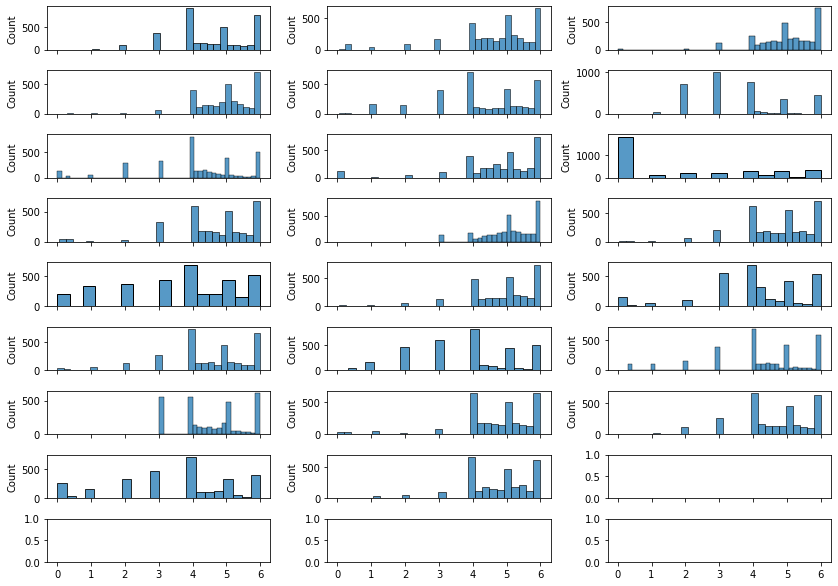

In [292]:
time_to_forget=pd.read_csv(f"../data/{phase}/time_to_forget.csv")
fig,axes=plt.subplots(9,3,figsize=(11.74,8.25),tight_layout=True,sharex=True)
axes=axes.flatten()

for i,species in enumerate(time_to_forget["Species"].unique()):
    idx=time_to_forget["Species"]==species
    idx=idx & (time_to_forget["Time"]>0)
    sns.histplot(np.log10(time_to_forget.loc[idx,"Time"]+1),ax=axes[i])


In [293]:
time_to_forget=pd.read_csv(f"../data/{phase}/time_to_forget.csv")
time_to_forget=time_to_forget.groupby("Species")["Time"].agg(lambda x: f"\num{{{np.percentile(x,50):.1e}}}")
result_df=result_df.merge(time_to_forget,on="Species")

In [294]:
def prettify(spec):
    for i in [2,3,4]:
        spec=spec.replace(f"{i}",f"$_{i}$")
    spec=spec.replace("+","$^+$")    
    return spec



result_df.loc[result_df["Collisional Data"],["Species","Percentage","Time"]].to_latex("../Paper/species.tex",index=False,formatters=[prettify,None,None],escape=False)
result_df.loc[~result_df["Collisional Data"],["Species","Percentage","Time"]].to_latex("../Paper/species_appendix.tex",index=False,formatters=[prettify,None,None],escape=False)

# Example Plotting
For the paper, we want to show a few examples of different physical parameters and the histories. Easy enough to plot similar to the above plots

In [295]:
paper_plot_df=pd.read_hdf(f"../data/{phase}/plot_models.hdf")
plot_specs=["CO","OH","H2O","H3O+","CH3CN"]
paper_plot_df=paper_plot_df[paper_plot_df["Species"].isin(plot_specs)]

In [296]:
history_join=pd.read_csv(f"../data/{phase}/histories.csv")
temp=history_join[["collapse","long","initialTemp"]].drop_duplicates()
temp["History"]=range(1,len(temp)+1)
history_join=history_join.merge(temp,on=["collapse","long","initialTemp"])
history_join["History"]=np.where(history_join["outputFile"].isna(),6,history_join["History"])
history_join=history_join[["outputFile","History"]]
history_join=history_join.fillna("No History").drop_duplicates()
paper_plot_df=paper_plot_df.merge(history_join,left_on="history",right_on="outputFile")

In [297]:
model_sets=paper_plot_df[["initialTemp","radfield","Av","zeta","initialDens"]].drop_duplicates().reset_index(drop=True)
model_sets=model_sets.loc[[2,5,1,6,0,4,3,7]].reset_index(drop=True)
labels=["Dark Cloud","","High Temperature","","High F$_{UV}$","","High $\zeta$",""]

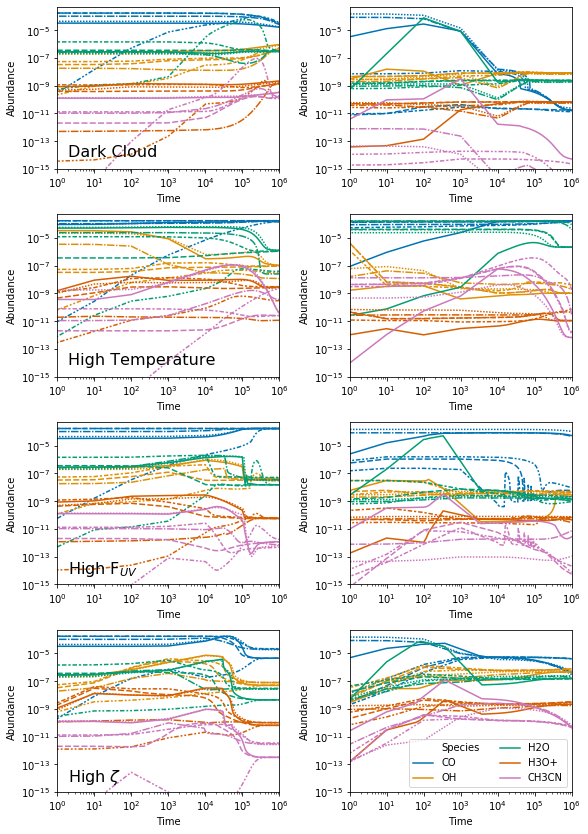

In [298]:
fig,axes=plt.subplots(4,2,figsize=(8.27,11.69),tight_layout=True)
axes=axes.flatten()
for i,model in model_sets.iterrows():
    plot_df=paper_plot_df.loc[np.all(paper_plot_df[["initialTemp","radfield","Av","zeta","initialDens"]]==model,axis=1)]
    sns.lineplot(data=plot_df,x="Time",y="Abundance",hue="Species",style="history",ax=axes[i],palette="colorblind")
    axes[i].text(0.05,0.15,labels[i],ha="left",va="top",fontsize=16,transform=axes[i].transAxes)
    if i!=7:
        axes[i].legend().remove()
    else:
        handles, leg_labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles[:6],leg_labels[:6],ncol=2)
    axes[i].set(yscale="log",xscale="log",xlim=(1,1e6),ylim=(1e-15,5e-4))
fig.savefig("../Paper/abundances.pdf",type="PDF")

In [299]:
model_sets

,initialTemp,radfield,Av,zeta,initialDens
0,11.015,6.753051,5.2885,1.768072,10000.0
1,11.015,6.753051,5.2885,1.768072,10000000.0
2,215.175,4.251087,7.8085,2.789331,10000.0
3,216.335,2.330773,2.9125,2.282969,10000000.0
4,28.995,145.044077,3.9745,1.817607,10000.0
5,28.995,145.044077,3.9745,1.817607,10000000.0
6,24.355,6.990367,7.2415,248.599356,10000.0
7,23.775,1.780328,6.9715,892.277620,10000000.0


In [300]:
models=pd.read_csv(f"../data/{phase}/models.csv")[physics].drop_duplicates()

idx=(models["initialDens"]==1e7) & (models["zeta"]<5) & (models["initialTemp"]<30)
idx = idx & (models["radfield"]>500) & (models["Av"]<10)
models.loc[idx].sample(1)

,initialTemp,radfield,Av,zeta,rout,initialDens
3335,11.595,996.55208,4.4875,3.20258,0.0003,10000000.0
